In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
FOLD=1

In [4]:
print FOLD

1


In [5]:
sys.path.insert(0,"../python/rrvf2017/")

In [6]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [7]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

0

# cv

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'                    
                    
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [25]:
j=FOLD
validpreds={}

In [26]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 40) (200606, 7, 32) (200606, 1) (200606, 1)
(200606, 264) (200606,) (200606,)
(50134, 1, 40) (50134, 7, 32) (50134, 1) (50134, 1)
(50134, 264) (50134,) (50134,)
(5803, 1, 40) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 264) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40146	valid-rmse:2.36306
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984282	valid-rmse:0.978514
[100]	train-rmse:0.571464	valid-rmse:0.585605
[150]	train-rmse:0.486924	valid-rmse:0.511135
[200]	train-rmse:0.470951	valid-rmse:0.500428
[250]	train-rmse:0.465644	valid-rmse:0.498972
[300]	train-rmse:0.46227	valid-rmse:0.498782
[350]	train-rmse:0.460016	valid-rmse:0.498823
Stopping. Best iteration:
[301]	train-rmse:0.462245	valid-rmse:0.498779

0.21367086 0.24878035
[0.24878035]
-1 mean score 0.24878035
0.192736953497


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925372  0.003738  0.199223    7  2017-04-16
472     2.507290  2.534184 -0.026893  0.212974    1  2017-04-17
473     2.661330  2.662254 -0.000925  0.224400    2  2017-04-18
474     2.754815  2.739132  0.015683  0.186555    3  2017-04-19
475     2.713762  2.706521  0.007241  0.212293    4  2017-04-20
476     2.999000  2.979392  0.019608  0.145240    5  2017-04-21
477     3.075529  3.073571  0.001958  0.168474    6  2017-04-22

0.192736953497


pred         y     error    error2  day        date
dayidx                                                         
471     2.925372  2.929110  0.003738  0.199223    7  2017-04-16
472     2.534184  2.507290 -0.026893  0.212974    1  2017-04-17
473     2.662254  2.661330 -0.000925  0.224400    2  2017-04-18
474     2.739132  2.754815  0.015683  0.186555    3  2017-04-19
475     2.706521  2.713762  0.007241  0.212293    4  2017-04-20
476     2.979392  2.999000  0.019608  0.145240    5  2017-04-21
477     3.073571  3.075529  0.001958  0.168474    6  2017-04-22

(829, 264)


In [27]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 40) (200381, 7, 32) (200381, 1) (200381, 1)
(200381, 264) (200381,) (200381,)
(50076, 1, 40) (50076, 7, 32) (50076, 1) (50076, 1)
(50076, 264) (50076,) (50076,)
(6632, 1, 40) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 264) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40128	valid-rmse:2.3626
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986527	valid-rmse:0.978618
[100]	train-rmse:0.575411	valid-rmse:0.588067
[150]	train-rmse:0.490778	valid-rmse:0.514947
[200]	train-rmse:0.47435	valid-rmse:0.504549
[250]	train-rmse:0.468543	valid-rmse:0.503168
[300]	train-rmse:0.464541	valid-rmse:0.503025
Stopping. Best iteration:
[297]	train-rmse:0.464694	valid-rmse:0.503015

0.21594062 0.25302398
[0.25302398]
-1 mean score 0.25302398
0.19370560348


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917402  0.011708  0.204043    7  2017-04-16
472     2.507290  2.532536 -0.025245  0.212734    1  2017-04-17
473     2.661330  2.660183  0.001146  0.220579    2  2017-04-18
474     2.754815  2.748301  0.006513  0.190238    3  2017-04-19
475     2.713762  2.712041  0.001721  0.215639    4  2017-04-20
476     2.999000  2.977757  0.021243  0.145777    5  2017-04-21
477     3.075529  3.064724  0.010806  0.166930    6  2017-04-22

0.19370560348


pred         y     error    error2  day        date
dayidx                                                         
471     2.917402  2.929110  0.011708  0.204043    7  2017-04-16
472     2.532536  2.507290 -0.025245  0.212734    1  2017-04-17
473     2.660183  2.661330  0.001146  0.220579    2  2017-04-18
474     2.748301  2.754815  0.006513  0.190238    3  2017-04-19
475     2.712041  2.713762  0.001721  0.215639    4  2017-04-20
476     2.977757  2.999000  0.021243  0.145777    5  2017-04-21
477     3.064724  3.075529  0.010806  0.166930    6  2017-04-22

(829, 264)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 40) (200200, 7, 32) (200200, 1) (200200, 1)
(200200, 264) (200200,) (200200,)
(50030, 1, 40) (50030, 7, 32) (50030, 1) (50030, 1)
(50030, 264) (50030,) (50030,)
(7461, 1, 40) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 264) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40108	valid-rmse:2.36251
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987379	valid-rmse:0.98201
[100]	train-rmse:0.57712	valid-rmse:0.591458
[150]	train-rmse:0.492876	valid-rmse:0.517
[200]	train-rmse:0.476374	valid-rmse:0.505995
[250]	train-rmse:0.470593	valid-rmse:0.504332
[300]	train-rmse:0.466389	valid-rmse:0.504089
[350]	train-rmse:0.463377	valid-rmse:0.504035
[400]	train-rmse:0.460506	valid-rmse:0.504036
Stopping. Best iteration:
[361]	train-rmse:0.462714	valid-rmse:0.504023

0.21410443 0.2540388
[0.2540388]
-1 mean score 0.2540388
0.194462627172


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906200  0.022910  0.201522    7  2017-04-16
472     2.507290  2.522756 -0.015465  0.211407    1  2017-04-17
473     2.661330  2.651529  0.009801  0.231374    2  2017-04-18
474     2.754815  2.761029 -0.006214  0.191637    3  2017-04-19
475     2.713762  2.715680 -0.001918  0.214273    4  2017-04-20
476     2.999000  2.977659  0.021340  0.145764    5  2017-04-21
477     3.075529  3.059080  0.016449  0.165261    6  2017-04-22

0.194462627172


pred         y     error    error2  day        date
dayidx                                                         
471     2.906200  2.929110  0.022910  0.201522    7  2017-04-16
472     2.522756  2.507290 -0.015465  0.211407    1  2017-04-17
473     2.651529  2.661330  0.009801  0.231374    2  2017-04-18
474     2.761029  2.754815 -0.006214  0.191637    3  2017-04-19
475     2.715680  2.713762 -0.001918  0.214273    4  2017-04-20
476     2.977659  2.999000  0.021340  0.145764    5  2017-04-21
477     3.059080  3.075529  0.016449  0.165261    6  2017-04-22

(829, 264)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 40) (200042, 7, 32) (200042, 1) (200042, 1)
(200042, 264) (200042,) (200042,)
(49986, 1, 40) (49986, 7, 32) (49986, 1) (49986, 1)
(49986, 264) (49986,) (49986,)
(8290, 1, 40) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 264) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40108	valid-rmse:2.36223
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988054	valid-rmse:0.977316
[100]	train-rmse:0.578435	valid-rmse:0.588344
[150]	train-rmse:0.494436	valid-rmse:0.516721
[200]	train-rmse:0.478027	valid-rmse:0.507044
[250]	train-rmse:0.472141	valid-rmse:0.50597
[300]	train-rmse:0.468397	valid-rmse:0.50592
Stopping. Best iteration:
[287]	train-rmse:0.469069	valid-rmse:0.50588

0.22002567 0.25591466
[0.25591466]
-1 mean score 0.25591466
0.197418779135


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903475  0.025635  0.205936    7  2017-04-16
472     2.507290  2.513556 -0.006266  0.216192    1  2017-04-17
473     2.661330  2.627555  0.033774  0.234723    2  2017-04-18
474     2.754815  2.741971  0.012843  0.194479    3  2017-04-19
475     2.713762  2.715407 -0.001645  0.213424    4  2017-04-20
476     2.999000  2.957846  0.041154  0.150048    5  2017-04-21
477     3.075529  3.054837  0.020692  0.167129    6  2017-04-22

0.197418779135


pred         y     error    error2  day        date
dayidx                                                         
471     2.903475  2.929110  0.025635  0.205936    7  2017-04-16
472     2.513556  2.507290 -0.006266  0.216192    1  2017-04-17
473     2.627555  2.661330  0.033774  0.234723    2  2017-04-18
474     2.741971  2.754815  0.012843  0.194479    3  2017-04-19
475     2.715407  2.713762 -0.001645  0.213424    4  2017-04-20
476     2.957846  2.999000  0.041154  0.150048    5  2017-04-21
477     3.054837  3.075529  0.020692  0.167129    6  2017-04-22

(829, 264)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 40) (199839, 7, 32) (199839, 1) (199839, 1)
(199839, 264) (199839,) (199839,)
(49937, 1, 40) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 264) (49937,) (49937,)
(9119, 1, 40) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 264) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4013	valid-rmse:2.36281
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988768	valid-rmse:0.984661
[100]	train-rmse:0.579319	valid-rmse:0.595085
[150]	train-rmse:0.495394	valid-rmse:0.520703
[200]	train-rmse:0.479125	valid-rmse:0.509437
[250]	train-rmse:0.473621	valid-rmse:0.507779
[300]	train-rmse:0.469615	valid-rmse:0.507477
[350]	train-rmse:0.466911	valid-rmse:0.507435
[400]	train-rmse:0.464256	valid-rmse:0.507469
Stopping. Best iteration:
[356]	train-rmse:0.466579	valid-rmse:0.507427

0.21769553 0.25748235
[0.25748235]
-1 mean score 0.25748235
0.196093559265


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913845  0.015265  0.202191    7  2017-04-16
472     2.507290  2.528301 -0.021010  0.216864    1  2017-04-17
473     2.661330  2.628543  0.032787  0.230795    2  2017-04-18
474     2.754815  2.735037  0.019777  0.191256    3  2017-04-19
475     2.713762  2.706170  0.007591  0.218910    4  2017-04-20
476     2.999000  2.969163  0.029836  0.146757    5  2017-04-21
477     3.075529  3.054259  0.021270  0.165882    6  2017-04-22

0.196093559265


pred         y     error    error2  day        date
dayidx                                                         
471     2.913845  2.929110  0.015265  0.202191    7  2017-04-16
472     2.528301  2.507290 -0.021010  0.216864    1  2017-04-17
473     2.628543  2.661330  0.032787  0.230795    2  2017-04-18
474     2.735037  2.754815  0.019777  0.191256    3  2017-04-19
475     2.706170  2.713762  0.007591  0.218910    4  2017-04-20
476     2.969163  2.999000  0.029836  0.146757    5  2017-04-21
477     3.054259  3.075529  0.021270  0.165882    6  2017-04-22

(829, 264)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 40) (199631, 7, 32) (199631, 1) (199631, 1)
(199631, 264) (199631,) (199631,)
(49882, 1, 40) (49882, 7, 32) (49882, 1) (49882, 1)
(49882, 264) (49882,) (49882,)
(9948, 1, 40) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 264) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40148	valid-rmse:2.3627
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989209	valid-rmse:0.981668
[100]	train-rmse:0.580354	valid-rmse:0.593185
[150]	train-rmse:0.496654	valid-rmse:0.520544
[200]	train-rmse:0.480372	valid-rmse:0.510216
[250]	train-rmse:0.474655	valid-rmse:0.508867
[300]	train-rmse:0.47078	valid-rmse:0.508697
[350]	train-rmse:0.467982	valid-rmse:0.508711
Stopping. Best iteration:
[314]	train-rmse:0.470033	valid-rmse:0.508692

0.22093071 0.25876752
[0.25876752]
-1 mean score 0.25876752
0.203026533127


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917295  0.011815  0.213519    7  2017-04-16
472     2.507290  2.532251 -0.024961  0.227867    1  2017-04-17
473     2.661330  2.627310  0.034019  0.240328    2  2017-04-18
474     2.754815  2.731377  0.023438  0.196306    3  2017-04-19
475     2.713762  2.716283 -0.002521  0.222559    4  2017-04-20
476     2.999000  2.954191  0.044808  0.152673    5  2017-04-21
477     3.075529  3.067539  0.007990  0.167933    6  2017-04-22

0.203026533127


pred         y     error    error2  day        date
dayidx                                                         
471     2.917295  2.929110  0.011815  0.213519    7  2017-04-16
472     2.532251  2.507290 -0.024961  0.227867    1  2017-04-17
473     2.627310  2.661330  0.034019  0.240328    2  2017-04-18
474     2.731377  2.754815  0.023438  0.196306    3  2017-04-19
475     2.716283  2.713762 -0.002521  0.222559    4  2017-04-20
476     2.954191  2.999000  0.044808  0.152673    5  2017-04-21
477     3.067539  3.075529  0.007990  0.167933    6  2017-04-22

(829, 264)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 40) (199412, 7, 32) (199412, 1) (199412, 1)
(199412, 264) (199412,) (199412,)
(49827, 1, 40) (49827, 7, 32) (49827, 1) (49827, 1)
(49827, 264) (49827,) (49827,)
(10777, 1, 40) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 264) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40158	valid-rmse:2.36288
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990283	valid-rmse:0.981402
[100]	train-rmse:0.582344	valid-rmse:0.594324
[150]	train-rmse:0.498999	valid-rmse:0.522685
[200]	train-rmse:0.482768	valid-rmse:0.512773
[250]	train-rmse:0.476988	valid-rmse:0.511509
[300]	train-rmse:0.473345	valid-rmse:0.511389
Stopping. Best iteration:
[288]	train-rmse:0.474003	valid-rmse:0.511357

0.22467907 0.26148573
[0.26148573]
-1 mean score 0.26148573
0.204891771078


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912333  0.016777  0.217201    7  2017-04-16
472     2.507290  2.544372 -0.037081  0.229289    1  2017-04-17
473     2.661330  2.632196  0.029133  0.243292    2  2017-04-18
474     2.754815  2.723600  0.031215  0.198694    3  2017-04-19
475     2.713762  2.704791  0.008971  0.224397    4  2017-04-20
476     2.999000  2.969105  0.029895  0.150726    5  2017-04-21
477     3.075529  3.080889 -0.005360  0.170644    6  2017-04-22

0.204891771078


pred         y     error    error2  day        date
dayidx                                                         
471     2.912333  2.929110  0.016777  0.217201    7  2017-04-16
472     2.544372  2.507290 -0.037081  0.229289    1  2017-04-17
473     2.632196  2.661330  0.029133  0.243292    2  2017-04-18
474     2.723600  2.754815  0.031215  0.198694    3  2017-04-19
475     2.704791  2.713762  0.008971  0.224397    4  2017-04-20
476     2.969105  2.999000  0.029895  0.150726    5  2017-04-21
477     3.080889  3.075529 -0.005360  0.170644    6  2017-04-22

(829, 264)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 40) (199179, 7, 32) (199179, 1) (199179, 1)
(199179, 264) (199179,) (199179,)
(49770, 1, 40) (49770, 7, 32) (49770, 1) (49770, 1)
(49770, 264) (49770,) (49770,)
(11606, 1, 40) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 264) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40149	valid-rmse:2.36287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991905	valid-rmse:0.987179
[100]	train-rmse:0.585466	valid-rmse:0.601263
[150]	train-rmse:0.502489	valid-rmse:0.528582
[200]	train-rmse:0.486376	valid-rmse:0.517851
[250]	train-rmse:0.480692	valid-rmse:0.516251
[300]	train-rmse:0.476602	valid-rmse:0.516041
[350]	train-rmse:0.473697	valid-rmse:0.515933
Stopping. Best iteration:
[340]	train-rmse:0.474185	valid-rmse:0.51592

0.22485186 0.26617336
[0.26617336]
-1 mean score 0.26617336
0.207799658179


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932296 -0.003186  0.222567    7  2017-04-16
472     2.507290  2.551436 -0.044146  0.226498    1  2017-04-17
473     2.661330  2.645494  0.015836  0.243667    2  2017-04-18
474     2.754815  2.731181  0.023634  0.204169    3  2017-04-19
475     2.713762  2.710081  0.003681  0.229072    4  2017-04-20
476     2.999000  2.961982  0.037018  0.157997    5  2017-04-21
477     3.075529  3.084134 -0.008605  0.170628    6  2017-04-22

0.207799658179


pred         y     error    error2  day        date
dayidx                                                         
471     2.932296  2.929110 -0.003186  0.222567    7  2017-04-16
472     2.551436  2.507290 -0.044146  0.226498    1  2017-04-17
473     2.645494  2.661330  0.015836  0.243667    2  2017-04-18
474     2.731181  2.754815  0.023634  0.204169    3  2017-04-19
475     2.710081  2.713762  0.003681  0.229072    4  2017-04-20
476     2.961982  2.999000  0.037018  0.157997    5  2017-04-21
477     3.084134  3.075529 -0.008605  0.170628    6  2017-04-22

(829, 264)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 40) (198954, 7, 32) (198954, 1) (198954, 1)
(198954, 264) (198954,) (198954,)
(49713, 1, 40) (49713, 7, 32) (49713, 1) (49713, 1)
(49713, 264) (49713,) (49713,)
(12435, 1, 40) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 264) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40122	valid-rmse:2.36252
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992705	valid-rmse:0.987285
[100]	train-rmse:0.586813	valid-rmse:0.602276
[150]	train-rmse:0.50392	valid-rmse:0.530102
[200]	train-rmse:0.487694	valid-rmse:0.519623
[250]	train-rmse:0.481742	valid-rmse:0.518044
[300]	train-rmse:0.477378	valid-rmse:0.517822
[350]	train-rmse:0.474207	valid-rmse:0.517833
Stopping. Best iteration:
[322]	train-rmse:0.475841	valid-rmse:0.517797

0.22642508 0.26811367
[0.26811367]
-1 mean score 0.26811367
0.208350658417


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922166  0.006944  0.224900    7  2017-04-16
472     2.507290  2.552555 -0.045264  0.226484    1  2017-04-17
473     2.661330  2.663373 -0.002043  0.243349    2  2017-04-18
474     2.754815  2.728316  0.026499  0.206940    3  2017-04-19
475     2.713762  2.709818  0.003943  0.228781    4  2017-04-20
476     2.999000  2.958687  0.040313  0.159389    5  2017-04-21
477     3.075529  3.073448  0.002081  0.168612    6  2017-04-22

0.208350658417


pred         y     error    error2  day        date
dayidx                                                         
471     2.922166  2.929110  0.006944  0.224900    7  2017-04-16
472     2.552555  2.507290 -0.045264  0.226484    1  2017-04-17
473     2.663373  2.661330 -0.002043  0.243349    2  2017-04-18
474     2.728316  2.754815  0.026499  0.206940    3  2017-04-19
475     2.709818  2.713762  0.003943  0.228781    4  2017-04-20
476     2.958687  2.999000  0.040313  0.159389    5  2017-04-21
477     3.073448  3.075529  0.002081  0.168612    6  2017-04-22

(829, 264)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 40) (198785, 7, 32) (198785, 1) (198785, 1)
(198785, 264) (198785,) (198785,)
(49666, 1, 40) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 264) (49666,) (49666,)
(13264, 1, 40) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 264) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4012	valid-rmse:2.3625
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993075	valid-rmse:0.987809
[100]	train-rmse:0.587609	valid-rmse:0.602326
[150]	train-rmse:0.505052	valid-rmse:0.529781
[200]	train-rmse:0.488696	valid-rmse:0.519125
[250]	train-rmse:0.482794	valid-rmse:0.517599
[300]	train-rmse:0.47834	valid-rmse:0.517347
[350]	train-rmse:0.475273	valid-rmse:0.517321
Stopping. Best iteration:
[324]	train-rmse:0.476704	valid-rmse:0.517305

0.22724628 0.26760453
[0.26760453]
-1 mean score 0.26760453
0.207507252693


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918754  0.010356  0.217005    7  2017-04-16
472     2.507290  2.534969 -0.027678  0.223022    1  2017-04-17
473     2.661330  2.667802 -0.006472  0.247780    2  2017-04-18
474     2.754815  2.743150  0.011664  0.206494    3  2017-04-19
475     2.713762  2.715684 -0.001923  0.228177    4  2017-04-20
476     2.999000  2.964842  0.034158  0.159531    5  2017-04-21
477     3.075529  3.079818 -0.004289  0.170541    6  2017-04-22

0.207507252693


pred         y     error    error2  day        date
dayidx                                                         
471     2.918754  2.929110  0.010356  0.217005    7  2017-04-16
472     2.534969  2.507290 -0.027678  0.223022    1  2017-04-17
473     2.667802  2.661330 -0.006472  0.247780    2  2017-04-18
474     2.743150  2.754815  0.011664  0.206494    3  2017-04-19
475     2.715684  2.713762 -0.001923  0.228177    4  2017-04-20
476     2.964842  2.999000  0.034158  0.159531    5  2017-04-21
477     3.079818  3.075529 -0.004289  0.170541    6  2017-04-22

(829, 264)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 40) (198605, 7, 32) (198605, 1) (198605, 1)
(198605, 264) (198605,) (198605,)
(49620, 1, 40) (49620, 7, 32) (49620, 1) (49620, 1)
(49620, 264) (49620,) (49620,)
(14093, 1, 40) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 264) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40148	valid-rmse:2.36279
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993405	valid-rmse:0.988721
[100]	train-rmse:0.588103	valid-rmse:0.603409
[150]	train-rmse:0.505425	valid-rmse:0.530844
[200]	train-rmse:0.489111	valid-rmse:0.520111
[250]	train-rmse:0.483221	valid-rmse:0.518476
[300]	train-rmse:0.47913	valid-rmse:0.518212
[350]	train-rmse:0.475377	valid-rmse:0.51815
[400]	train-rmse:0.472033	valid-rmse:0.518165
Stopping. Best iteration:
[389]	train-rmse:0.472838	valid-rmse:0.518122

0.22357534 0.26845017
[0.26845017]
-1 mean score 0.26845017
0.205123886466


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915647  0.013463  0.212684    7  2017-04-16
472     2.507290  2.541933 -0.034643  0.221154    1  2017-04-17
473     2.661330  2.660490  0.000840  0.251084    2  2017-04-18
474     2.754815  2.728394  0.026421  0.201306    3  2017-04-19
475     2.713762  2.730407 -0.016646  0.224292    4  2017-04-20
476     2.999000  2.974414  0.024585  0.157003    5  2017-04-21
477     3.075529  3.069374  0.006155  0.168344    6  2017-04-22

0.205123886466


pred         y     error    error2  day        date
dayidx                                                         
471     2.915647  2.929110  0.013463  0.212684    7  2017-04-16
472     2.541933  2.507290 -0.034643  0.221154    1  2017-04-17
473     2.660490  2.661330  0.000840  0.251084    2  2017-04-18
474     2.728394  2.754815  0.026421  0.201306    3  2017-04-19
475     2.730407  2.713762 -0.016646  0.224292    4  2017-04-20
476     2.974414  2.999000  0.024585  0.157003    5  2017-04-21
477     3.069374  3.075529  0.006155  0.168344    6  2017-04-22

(829, 264)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 40) (198392, 7, 32) (198392, 1) (198392, 1)
(198392, 264) (198392,) (198392,)
(49566, 1, 40) (49566, 7, 32) (49566, 1) (49566, 1)
(49566, 264) (49566,) (49566,)
(14922, 1, 40) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 264) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40171	valid-rmse:2.36298
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994141	valid-rmse:0.988781
[100]	train-rmse:0.58925	valid-rmse:0.604465
[150]	train-rmse:0.506806	valid-rmse:0.532629
[200]	train-rmse:0.490674	valid-rmse:0.522148
[250]	train-rmse:0.484782	valid-rmse:0.520621
[300]	train-rmse:0.480534	valid-rmse:0.520382
Stopping. Best iteration:
[298]	train-rmse:0.480671	valid-rmse:0.520378

0.23104435 0.27079365
[0.27079365]
-1 mean score 0.27079365
0.211310699582


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899981  0.029128  0.230301    7  2017-04-16
472     2.507290  2.542408 -0.035117  0.225355    1  2017-04-17
473     2.661330  2.662212 -0.000882  0.253501    2  2017-04-18
474     2.754815  2.720629  0.034185  0.208992    3  2017-04-19
475     2.713762  2.727722 -0.013960  0.227704    4  2017-04-20
476     2.999000  2.969092  0.029908  0.162826    5  2017-04-21
477     3.075529  3.067149  0.008381  0.170497    6  2017-04-22

0.211310699582


pred         y     error    error2  day        date
dayidx                                                         
471     2.899981  2.929110  0.029128  0.230301    7  2017-04-16
472     2.542408  2.507290 -0.035117  0.225355    1  2017-04-17
473     2.662212  2.661330 -0.000882  0.253501    2  2017-04-18
474     2.720629  2.754815  0.034185  0.208992    3  2017-04-19
475     2.727722  2.713762 -0.013960  0.227704    4  2017-04-20
476     2.969092  2.999000  0.029908  0.162826    5  2017-04-21
477     3.067149  3.075529  0.008381  0.170497    6  2017-04-22

(829, 264)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 40) (198182, 7, 32) (198182, 1) (198182, 1)
(198182, 264) (198182,) (198182,)
(49513, 1, 40) (49513, 7, 32) (49513, 1) (49513, 1)
(49513, 264) (49513,) (49513,)
(15751, 1, 40) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 264) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40181	valid-rmse:2.36308
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99464	valid-rmse:0.988793
[100]	train-rmse:0.590086	valid-rmse:0.604782
[150]	train-rmse:0.507541	valid-rmse:0.533158
[200]	train-rmse:0.491253	valid-rmse:0.522855
[250]	train-rmse:0.48528	valid-rmse:0.521334
[300]	train-rmse:0.481196	valid-rmse:0.521143
Stopping. Best iteration:
[294]	train-rmse:0.481672	valid-rmse:0.521128

0.23200762 0.27157393
[0.27157393]
-1 mean score 0.27157393
0.212099522352


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901711  0.027399  0.229322    7  2017-04-16
472     2.507290  2.530978 -0.023688  0.230697    1  2017-04-17
473     2.661330  2.666251 -0.004921  0.253400    2  2017-04-18
474     2.754815  2.723208  0.031607  0.212815    3  2017-04-19
475     2.713762  2.726008 -0.012246  0.226482    4  2017-04-20
476     2.999000  2.986938  0.012061  0.159592    5  2017-04-21
477     3.075529  3.059367  0.016162  0.172389    6  2017-04-22

0.212099522352


pred         y     error    error2  day        date
dayidx                                                         
471     2.901711  2.929110  0.027399  0.229322    7  2017-04-16
472     2.530978  2.507290 -0.023688  0.230697    1  2017-04-17
473     2.666251  2.661330 -0.004921  0.253400    2  2017-04-18
474     2.723208  2.754815  0.031607  0.212815    3  2017-04-19
475     2.726008  2.713762 -0.012246  0.226482    4  2017-04-20
476     2.986938  2.999000  0.012061  0.159592    5  2017-04-21
477     3.059367  3.075529  0.016162  0.172389    6  2017-04-22

(829, 264)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 40) (197959, 7, 32) (197959, 1) (197959, 1)
(197959, 264) (197959,) (197959,)
(49458, 1, 40) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 264) (49458,) (49458,)
(16580, 1, 40) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 264) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40188	valid-rmse:2.36322
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995048	valid-rmse:0.990106
[100]	train-rmse:0.591023	valid-rmse:0.606332
[150]	train-rmse:0.508898	valid-rmse:0.534402
[200]	train-rmse:0.492719	valid-rmse:0.523884
[250]	train-rmse:0.486977	valid-rmse:0.522275
[300]	train-rmse:0.482917	valid-rmse:0.521984
[350]	train-rmse:0.479645	valid-rmse:0.521982
Stopping. Best iteration:
[312]	train-rmse:0.482239	valid-rmse:0.521954

0.23255444 0.27243638
[0.27243638]
-1 mean score 0.27243638
0.212292045355


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903038  0.026072  0.230486    7  2017-04-16
472     2.507290  2.527215 -0.019924  0.222547    1  2017-04-17
473     2.661330  2.657330  0.004000  0.255723    2  2017-04-18
474     2.754815  2.724618  0.030197  0.218989    3  2017-04-19
475     2.713762  2.728055 -0.014294  0.229151    4  2017-04-20
476     2.999000  2.994460  0.004540  0.154966    5  2017-04-21
477     3.075529  3.071628  0.003902  0.174184    6  2017-04-22

0.212292045355


pred         y     error    error2  day        date
dayidx                                                         
471     2.903038  2.929110  0.026072  0.230486    7  2017-04-16
472     2.527215  2.507290 -0.019924  0.222547    1  2017-04-17
473     2.657330  2.661330  0.004000  0.255723    2  2017-04-18
474     2.724618  2.754815  0.030197  0.218989    3  2017-04-19
475     2.728055  2.713762 -0.014294  0.229151    4  2017-04-20
476     2.994460  2.999000  0.004540  0.154966    5  2017-04-21
477     3.071628  3.075529  0.003902  0.174184    6  2017-04-22

(829, 264)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 40) (197725, 7, 32) (197725, 1) (197725, 1)
(197725, 264) (197725,) (197725,)
(49402, 1, 40) (49402, 7, 32) (49402, 1) (49402, 1)
(49402, 264) (49402,) (49402,)
(17409, 1, 40) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 264) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40178	valid-rmse:2.36308
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99662	valid-rmse:0.991952
[100]	train-rmse:0.593972	valid-rmse:0.609077
[150]	train-rmse:0.512093	valid-rmse:0.537214
[200]	train-rmse:0.495916	valid-rmse:0.526513
[250]	train-rmse:0.490046	valid-rmse:0.524826
[300]	train-rmse:0.485774	valid-rmse:0.524538
[350]	train-rmse:0.482362	valid-rmse:0.524584
Stopping. Best iteration:
[311]	train-rmse:0.484996	valid-rmse:0.52451

0.23522109 0.27511072
[0.27511072]
-1 mean score 0.27511072
0.216229811311


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904264  0.024846  0.232790    7  2017-04-16
472     2.507290  2.532668 -0.025377  0.230220    1  2017-04-17
473     2.661330  2.646670  0.014660  0.266113    2  2017-04-18
474     2.754815  2.717745  0.037070  0.213335    3  2017-04-19
475     2.713762  2.730017 -0.016256  0.235638    4  2017-04-20
476     2.999000  2.991446  0.007553  0.161275    5  2017-04-21
477     3.075529  3.068936  0.006593  0.174237    6  2017-04-22

0.216229811311


pred         y     error    error2  day        date
dayidx                                                         
471     2.904264  2.929110  0.024846  0.232790    7  2017-04-16
472     2.532668  2.507290 -0.025377  0.230220    1  2017-04-17
473     2.646670  2.661330  0.014660  0.266113    2  2017-04-18
474     2.717745  2.754815  0.037070  0.213335    3  2017-04-19
475     2.730017  2.713762 -0.016256  0.235638    4  2017-04-20
476     2.991446  2.999000  0.007553  0.161275    5  2017-04-21
477     3.068936  3.075529  0.006593  0.174237    6  2017-04-22

(829, 264)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 40) (197493, 7, 32) (197493, 1) (197493, 1)
(197493, 264) (197493,) (197493,)
(49345, 1, 40) (49345, 7, 32) (49345, 1) (49345, 1)
(49345, 264) (49345,) (49345,)
(18238, 1, 40) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 264) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40157	valid-rmse:2.36277
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997261	valid-rmse:0.990703
[100]	train-rmse:0.595112	valid-rmse:0.609098
[150]	train-rmse:0.513401	valid-rmse:0.538472
[200]	train-rmse:0.497184	valid-rmse:0.528325
[250]	train-rmse:0.491108	valid-rmse:0.526806
[300]	train-rmse:0.48721	valid-rmse:0.526589
Stopping. Best iteration:
[290]	train-rmse:0.487876	valid-rmse:0.526566

0.23802271 0.27727145
[0.27727145]
-1 mean score 0.27727145
0.216490492225


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898874  0.030236  0.234851    7  2017-04-16
472     2.507290  2.536205 -0.028914  0.229369    1  2017-04-17
473     2.661330  2.640262  0.021068  0.258722    2  2017-04-18
474     2.754815  2.709057  0.045758  0.216298    3  2017-04-19
475     2.713762  2.720485 -0.006723  0.234789    4  2017-04-20
476     2.999000  2.985149  0.013850  0.163938    5  2017-04-21
477     3.075529  3.057000  0.018529  0.177465    6  2017-04-22

0.216490492225


pred         y     error    error2  day        date
dayidx                                                         
471     2.898874  2.929110  0.030236  0.234851    7  2017-04-16
472     2.536205  2.507290 -0.028914  0.229369    1  2017-04-17
473     2.640262  2.661330  0.021068  0.258722    2  2017-04-18
474     2.709057  2.754815  0.045758  0.216298    3  2017-04-19
475     2.720485  2.713762 -0.006723  0.234789    4  2017-04-20
476     2.985149  2.999000  0.013850  0.163938    5  2017-04-21
477     3.057000  3.075529  0.018529  0.177465    6  2017-04-22

(829, 264)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 40) (197331, 7, 32) (197331, 1) (197331, 1)
(197331, 264) (197331,) (197331,)
(49305, 1, 40) (49305, 7, 32) (49305, 1) (49305, 1)
(49305, 264) (49305,) (49305,)
(19067, 1, 40) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 264) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40161	valid-rmse:2.36276
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997711	valid-rmse:0.994529
[100]	train-rmse:0.596029	valid-rmse:0.612518
[150]	train-rmse:0.514556	valid-rmse:0.540113
[200]	train-rmse:0.498178	valid-rmse:0.529031
[250]	train-rmse:0.492152	valid-rmse:0.5272
[300]	train-rmse:0.487907	valid-rmse:0.526857
[350]	train-rmse:0.484655	valid-rmse:0.526906
Stopping. Best iteration:
[317]	train-rmse:0.486814	valid-rmse:0.526822

0.23698787 0.27754188
[0.27754188]
-1 mean score 0.27754188
0.215639546514


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907917  0.021193  0.231346    7  2017-04-16
472     2.507290  2.523733 -0.016443  0.227321    1  2017-04-17
473     2.661330  2.633807  0.027523  0.262172    2  2017-04-18
474     2.754815  2.710516  0.044299  0.218577    3  2017-04-19
475     2.713762  2.718791 -0.005029  0.231085    4  2017-04-20
476     2.999000  2.985301  0.013699  0.163286    5  2017-04-21
477     3.075529  3.055811  0.019718  0.175690    6  2017-04-22

0.215639546514


pred         y     error    error2  day        date
dayidx                                                         
471     2.907917  2.929110  0.021193  0.231346    7  2017-04-16
472     2.523733  2.507290 -0.016443  0.227321    1  2017-04-17
473     2.633807  2.661330  0.027523  0.262172    2  2017-04-18
474     2.710516  2.754815  0.044299  0.218577    3  2017-04-19
475     2.718791  2.713762 -0.005029  0.231085    4  2017-04-20
476     2.985301  2.999000  0.013699  0.163286    5  2017-04-21
477     3.055811  3.075529  0.019718  0.175690    6  2017-04-22

(829, 264)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 40) (197143, 7, 32) (197143, 1) (197143, 1)
(197143, 264) (197143,) (197143,)
(49257, 1, 40) (49257, 7, 32) (49257, 1) (49257, 1)
(49257, 264) (49257,) (49257,)
(19896, 1, 40) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 264) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4018	valid-rmse:2.36269
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99822	valid-rmse:0.98862
[100]	train-rmse:0.59679	valid-rmse:0.608012
[150]	train-rmse:0.515431	valid-rmse:0.538672
[200]	train-rmse:0.499067	valid-rmse:0.529229
[250]	train-rmse:0.493167	valid-rmse:0.528072
[300]	train-rmse:0.489088	valid-rmse:0.527925
[350]	train-rmse:0.485503	valid-rmse:0.527997
Stopping. Best iteration:
[315]	train-rmse:0.488045	valid-rmse:0.527914

0.23818782 0.2786936
[0.2786936]
-1 mean score 0.2786936
0.21892246604


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907690  0.021420  0.237845    7  2017-04-16
472     2.507290  2.527034 -0.019743  0.233285    1  2017-04-17
473     2.661330  2.632380  0.028950  0.259798    2  2017-04-18
474     2.754815  2.716725  0.038090  0.217045    3  2017-04-19
475     2.713762  2.722549 -0.008787  0.240163    4  2017-04-20
476     2.999000  2.981770  0.017230  0.166224    5  2017-04-21
477     3.075529  3.056886  0.018643  0.178097    6  2017-04-22

0.21892246604


pred         y     error    error2  day        date
dayidx                                                         
471     2.907690  2.929110  0.021420  0.237845    7  2017-04-16
472     2.527034  2.507290 -0.019743  0.233285    1  2017-04-17
473     2.632380  2.661330  0.028950  0.259798    2  2017-04-18
474     2.716725  2.754815  0.038090  0.217045    3  2017-04-19
475     2.722549  2.713762 -0.008787  0.240163    4  2017-04-20
476     2.981770  2.999000  0.017230  0.166224    5  2017-04-21
477     3.056886  3.075529  0.018643  0.178097    6  2017-04-22

(829, 264)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 40) (196929, 7, 32) (196929, 1) (196929, 1)
(196929, 264) (196929,) (196929,)
(49206, 1, 40) (49206, 7, 32) (49206, 1) (49206, 1)
(49206, 264) (49206,) (49206,)
(20725, 1, 40) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 264) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40192	valid-rmse:2.36305
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998615	valid-rmse:0.990733
[100]	train-rmse:0.59736	valid-rmse:0.609681
[150]	train-rmse:0.516029	valid-rmse:0.539491
[200]	train-rmse:0.499946	valid-rmse:0.529548
[250]	train-rmse:0.493965	valid-rmse:0.528126
[300]	train-rmse:0.489813	valid-rmse:0.528023
Stopping. Best iteration:
[270]	train-rmse:0.492128	valid-rmse:0.528012

0.24218959 0.2787962
[0.2787962]
-1 mean score 0.2787962
0.222278863192


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917590  0.011520  0.240557    7  2017-04-16
472     2.507290  2.522897 -0.015606  0.235178    1  2017-04-17
473     2.661330  2.616517  0.044812  0.261369    2  2017-04-18
474     2.754815  2.704003  0.050812  0.224705    3  2017-04-19
475     2.713762  2.702733  0.011029  0.240347    4  2017-04-20
476     2.999000  2.968142  0.030858  0.169451    5  2017-04-21
477     3.075529  3.044713  0.030817  0.184346    6  2017-04-22

0.222278863192


pred         y     error    error2  day        date
dayidx                                                         
471     2.917590  2.929110  0.011520  0.240557    7  2017-04-16
472     2.522897  2.507290 -0.015606  0.235178    1  2017-04-17
473     2.616517  2.661330  0.044812  0.261369    2  2017-04-18
474     2.704003  2.754815  0.050812  0.224705    3  2017-04-19
475     2.702733  2.713762  0.011029  0.240347    4  2017-04-20
476     2.968142  2.999000  0.030858  0.169451    5  2017-04-21
477     3.044713  3.075529  0.030817  0.184346    6  2017-04-22

(829, 264)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 40) (196711, 7, 32) (196711, 1) (196711, 1)
(196711, 264) (196711,) (196711,)
(49150, 1, 40) (49150, 7, 32) (49150, 1) (49150, 1)
(49150, 264) (49150,) (49150,)
(21554, 1, 40) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 264) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40198	valid-rmse:2.3631
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998685	valid-rmse:0.991714
[100]	train-rmse:0.597334	valid-rmse:0.610392
[150]	train-rmse:0.515864	valid-rmse:0.539503
[200]	train-rmse:0.499614	valid-rmse:0.529241
[250]	train-rmse:0.493709	valid-rmse:0.527761
[300]	train-rmse:0.489598	valid-rmse:0.527543
Stopping. Best iteration:
[299]	train-rmse:0.489649	valid-rmse:0.52754

0.2397566 0.27829885
[0.27829885]
-1 mean score 0.27829885
0.219280526042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921209  0.007901  0.234967    7  2017-04-16
472     2.507290  2.544903 -0.037612  0.233556    1  2017-04-17
473     2.661330  2.625330  0.036000  0.255136    2  2017-04-18
474     2.754815  2.711334  0.043481  0.218660    3  2017-04-19
475     2.713762  2.707685  0.006077  0.240628    4  2017-04-20
476     2.999000  2.965854  0.033146  0.168239    5  2017-04-21
477     3.075529  3.060476  0.015054  0.183779    6  2017-04-22

0.219280526042


pred         y     error    error2  day        date
dayidx                                                         
471     2.921209  2.929110  0.007901  0.234967    7  2017-04-16
472     2.544903  2.507290 -0.037612  0.233556    1  2017-04-17
473     2.625330  2.661330  0.036000  0.255136    2  2017-04-18
474     2.711334  2.754815  0.043481  0.218660    3  2017-04-19
475     2.707685  2.713762  0.006077  0.240628    4  2017-04-20
476     2.965854  2.999000  0.033146  0.168239    5  2017-04-21
477     3.060476  3.075529  0.015054  0.183779    6  2017-04-22

(829, 264)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 40) (196485, 7, 32) (196485, 1) (196485, 1)
(196485, 264) (196485,) (196485,)
(49095, 1, 40) (49095, 7, 32) (49095, 1) (49095, 1)
(49095, 264) (49095,) (49095,)
(22383, 1, 40) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 264) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40208	valid-rmse:2.36322
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999339	valid-rmse:0.991098
[100]	train-rmse:0.59848	valid-rmse:0.610427
[150]	train-rmse:0.517069	valid-rmse:0.540336
[200]	train-rmse:0.50061	valid-rmse:0.530295
[250]	train-rmse:0.494307	valid-rmse:0.528938
[300]	train-rmse:0.490017	valid-rmse:0.528824
Stopping. Best iteration:
[291]	train-rmse:0.490694	valid-rmse:0.528809

0.24078026 0.27963898
[0.27963898]
-1 mean score 0.27963898
0.21551387012


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898379  0.030731  0.236649    7  2017-04-16
472     2.507290  2.528929 -0.021639  0.225484    1  2017-04-17
473     2.661330  2.637663  0.023667  0.251014    2  2017-04-18
474     2.754815  2.713619  0.041196  0.213090    3  2017-04-19
475     2.713762  2.690634  0.023127  0.236204    4  2017-04-20
476     2.999000  2.960260  0.038740  0.168644    5  2017-04-21
477     3.075529  3.054537  0.020993  0.177512    6  2017-04-22

0.21551387012


pred         y     error    error2  day        date
dayidx                                                         
471     2.898379  2.929110  0.030731  0.236649    7  2017-04-16
472     2.528929  2.507290 -0.021639  0.225484    1  2017-04-17
473     2.637663  2.661330  0.023667  0.251014    2  2017-04-18
474     2.713619  2.754815  0.041196  0.213090    3  2017-04-19
475     2.690634  2.713762  0.023127  0.236204    4  2017-04-20
476     2.960260  2.999000  0.038740  0.168644    5  2017-04-21
477     3.054537  3.075529  0.020993  0.177512    6  2017-04-22

(829, 264)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 40) (196255, 7, 32) (196255, 1) (196255, 1)
(196255, 264) (196255,) (196255,)
(49037, 1, 40) (49037, 7, 32) (49037, 1) (49037, 1)
(49037, 264) (49037,) (49037,)
(23212, 1, 40) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 264) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40205	valid-rmse:2.3632
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00027	valid-rmse:0.992601
[100]	train-rmse:0.599992	valid-rmse:0.612603
[150]	train-rmse:0.518869	valid-rmse:0.54254
[200]	train-rmse:0.502399	valid-rmse:0.532724
[250]	train-rmse:0.496284	valid-rmse:0.531404
[300]	train-rmse:0.491865	valid-rmse:0.531343
Stopping. Best iteration:
[286]	train-rmse:0.493055	valid-rmse:0.531271

0.24310358 0.28224912
[0.28224912]
-1 mean score 0.28224912
0.218374803662


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907665  0.021445  0.229902    7  2017-04-16
472     2.507290  2.512244 -0.004954  0.229478    1  2017-04-17
473     2.661330  2.637732  0.023597  0.254766    2  2017-04-18
474     2.754815  2.722797  0.032017  0.216457    3  2017-04-19
475     2.713762  2.698109  0.015653  0.243260    4  2017-04-20
476     2.999000  2.955719  0.043280  0.172233    5  2017-04-21
477     3.075529  3.045790  0.029739  0.182527    6  2017-04-22

0.218374803662


pred         y     error    error2  day        date
dayidx                                                         
471     2.907665  2.929110  0.021445  0.229902    7  2017-04-16
472     2.512244  2.507290 -0.004954  0.229478    1  2017-04-17
473     2.637732  2.661330  0.023597  0.254766    2  2017-04-18
474     2.722797  2.754815  0.032017  0.216457    3  2017-04-19
475     2.698109  2.713762  0.015653  0.243260    4  2017-04-20
476     2.955719  2.999000  0.043280  0.172233    5  2017-04-21
477     3.045790  3.075529  0.029739  0.182527    6  2017-04-22

(829, 264)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 40) (196025, 7, 32) (196025, 1) (196025, 1)
(196025, 264) (196025,) (196025,)
(48978, 1, 40) (48978, 7, 32) (48978, 1) (48978, 1)
(48978, 264) (48978,) (48978,)
(24041, 1, 40) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 264) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40178	valid-rmse:2.36275
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00063	valid-rmse:0.989025
[100]	train-rmse:0.600974	valid-rmse:0.610643
[150]	train-rmse:0.51994	valid-rmse:0.542654
[200]	train-rmse:0.503656	valid-rmse:0.533716
[250]	train-rmse:0.497433	valid-rmse:0.532711
[300]	train-rmse:0.493201	valid-rmse:0.53272
Stopping. Best iteration:
[266]	train-rmse:0.495867	valid-rmse:0.532662

0.24588403 0.28372908
[0.28372908]
-1 mean score 0.28372908
0.219759687781


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897896  0.031214  0.234014    7  2017-04-16
472     2.507290  2.511709 -0.004419  0.229286    1  2017-04-17
473     2.661330  2.646448  0.014882  0.255658    2  2017-04-18
474     2.754815  2.715896  0.038919  0.219949    3  2017-04-19
475     2.713762  2.707802  0.005959  0.241348    4  2017-04-20
476     2.999000  2.957103  0.041896  0.173990    5  2017-04-21
477     3.075529  3.040689  0.034841  0.184072    6  2017-04-22

0.219759687781


pred         y     error    error2  day        date
dayidx                                                         
471     2.897896  2.929110  0.031214  0.234014    7  2017-04-16
472     2.511709  2.507290 -0.004419  0.229286    1  2017-04-17
473     2.646448  2.661330  0.014882  0.255658    2  2017-04-18
474     2.715896  2.754815  0.038919  0.219949    3  2017-04-19
475     2.707802  2.713762  0.005959  0.241348    4  2017-04-20
476     2.957103  2.999000  0.041896  0.173990    5  2017-04-21
477     3.040689  3.075529  0.034841  0.184072    6  2017-04-22

(829, 264)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 40) (195855, 7, 32) (195855, 1) (195855, 1)
(195855, 264) (195855,) (195855,)
(48933, 1, 40) (48933, 7, 32) (48933, 1) (48933, 1)
(48933, 264) (48933,) (48933,)
(24870, 1, 40) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 264) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40171	valid-rmse:2.36323
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00085	valid-rmse:1.00006
[100]	train-rmse:0.601241	valid-rmse:0.619942
[150]	train-rmse:0.520091	valid-rmse:0.547412
[200]	train-rmse:0.503435	valid-rmse:0.536036
[250]	train-rmse:0.497163	valid-rmse:0.534077
[300]	train-rmse:0.493019	valid-rmse:0.533674
[350]	train-rmse:0.490073	valid-rmse:0.533671
Stopping. Best iteration:
[322]	train-rmse:0.491807	valid-rmse:0.533651

0.24187407 0.28478342
[0.28478342]
-1 mean score 0.28478342
0.217432022095


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907314  0.021796  0.233539    7  2017-04-16
472     2.507290  2.507672 -0.000381  0.225348    1  2017-04-17
473     2.661330  2.638046  0.023284  0.251469    2  2017-04-18
474     2.754815  2.729713  0.025101  0.220253    3  2017-04-19
475     2.713762  2.700712  0.013049  0.241289    4  2017-04-20
476     2.999000  2.977638  0.021362  0.169497    5  2017-04-21
477     3.075529  3.048205  0.027324  0.180629    6  2017-04-22

0.217432022095


pred         y     error    error2  day        date
dayidx                                                         
471     2.907314  2.929110  0.021796  0.233539    7  2017-04-16
472     2.507672  2.507290 -0.000381  0.225348    1  2017-04-17
473     2.638046  2.661330  0.023284  0.251469    2  2017-04-18
474     2.729713  2.754815  0.025101  0.220253    3  2017-04-19
475     2.700712  2.713762  0.013049  0.241289    4  2017-04-20
476     2.977638  2.999000  0.021362  0.169497    5  2017-04-21
477     3.048205  3.075529  0.027324  0.180629    6  2017-04-22

(829, 264)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 40) (195669, 7, 32) (195669, 1) (195669, 1)
(195669, 264) (195669,) (195669,)
(48889, 1, 40) (48889, 7, 32) (48889, 1) (48889, 1)
(48889, 264) (48889,) (48889,)
(25699, 1, 40) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 264) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40191	valid-rmse:2.36311
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00122	valid-rmse:0.993526
[100]	train-rmse:0.60169	valid-rmse:0.614726
[150]	train-rmse:0.520743	valid-rmse:0.545177
[200]	train-rmse:0.504225	valid-rmse:0.535529
[250]	train-rmse:0.498063	valid-rmse:0.534192
[300]	train-rmse:0.493931	valid-rmse:0.534079
Stopping. Best iteration:
[286]	train-rmse:0.494885	valid-rmse:0.534029

0.24491073 0.28518674
[0.28518674]
-1 mean score 0.28518674
0.219598546624


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902709  0.026401  0.233228    7  2017-04-16
472     2.507290  2.501091  0.006200  0.229986    1  2017-04-17
473     2.661330  2.636152  0.025177  0.262336    2  2017-04-18
474     2.754815  2.713010  0.041805  0.222261    3  2017-04-19
475     2.713762  2.688907  0.024854  0.239817    4  2017-04-20
476     2.999000  2.975268  0.023732  0.166059    5  2017-04-21
477     3.075529  3.062068  0.013461  0.183504    6  2017-04-22

0.219598546624


pred         y     error    error2  day        date
dayidx                                                         
471     2.902709  2.929110  0.026401  0.233228    7  2017-04-16
472     2.501091  2.507290  0.006200  0.229986    1  2017-04-17
473     2.636152  2.661330  0.025177  0.262336    2  2017-04-18
474     2.713010  2.754815  0.041805  0.222261    3  2017-04-19
475     2.688907  2.713762  0.024854  0.239817    4  2017-04-20
476     2.975268  2.999000  0.023732  0.166059    5  2017-04-21
477     3.062068  3.075529  0.013461  0.183504    6  2017-04-22

(829, 264)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 40) (195451, 7, 32) (195451, 1) (195451, 1)
(195451, 264) (195451,) (195451,)
(48836, 1, 40) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 264) (48836,) (48836,)
(26528, 1, 40) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 264) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40211	valid-rmse:2.36347
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00174	valid-rmse:0.99484
[100]	train-rmse:0.602648	valid-rmse:0.616579
[150]	train-rmse:0.521491	valid-rmse:0.546972
[200]	train-rmse:0.505288	valid-rmse:0.53698
[250]	train-rmse:0.498852	valid-rmse:0.535618
[300]	train-rmse:0.494285	valid-rmse:0.535504
Stopping. Best iteration:
[289]	train-rmse:0.495315	valid-rmse:0.535466

0.24533725 0.28672343
[0.28672343]
-1 mean score 0.28672343
0.222507342696


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907758  0.021352  0.244430    7  2017-04-16
472     2.507290  2.514601 -0.007311  0.230048    1  2017-04-17
473     2.661330  2.633254  0.028076  0.264551    2  2017-04-18
474     2.754815  2.715571  0.039244  0.223528    3  2017-04-19
475     2.713762  2.691463  0.022299  0.241240    4  2017-04-20
476     2.999000  2.971628  0.027372  0.169440    5  2017-04-21
477     3.075529  3.056433  0.019096  0.184316    6  2017-04-22

0.222507342696


pred         y     error    error2  day        date
dayidx                                                         
471     2.907758  2.929110  0.021352  0.244430    7  2017-04-16
472     2.514601  2.507290 -0.007311  0.230048    1  2017-04-17
473     2.633254  2.661330  0.028076  0.264551    2  2017-04-18
474     2.715571  2.754815  0.039244  0.223528    3  2017-04-19
475     2.691463  2.713762  0.022299  0.241240    4  2017-04-20
476     2.971628  2.999000  0.027372  0.169440    5  2017-04-21
477     3.056433  3.075529  0.019096  0.184316    6  2017-04-22

(829, 264)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 40) (195240, 7, 32) (195240, 1) (195240, 1)
(195240, 264) (195240,) (195240,)
(48779, 1, 40) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 264) (48779,) (48779,)
(27357, 1, 40) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 264) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40224	valid-rmse:2.36372
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0021	valid-rmse:0.993528
[100]	train-rmse:0.603	valid-rmse:0.615601
[150]	train-rmse:0.522137	valid-rmse:0.546617
[200]	train-rmse:0.505618	valid-rmse:0.53702
[250]	train-rmse:0.499433	valid-rmse:0.535773
[300]	train-rmse:0.495143	valid-rmse:0.535682
Stopping. Best iteration:
[282]	train-rmse:0.496413	valid-rmse:0.535641

0.24642585 0.28691092
[0.28691092]
-1 mean score 0.28691092
0.222239643335


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891792  0.037318  0.239748    7  2017-04-16
472     2.507290  2.518769 -0.011478  0.233286    1  2017-04-17
473     2.661330  2.644288  0.017042  0.262040    2  2017-04-18
474     2.754815  2.720597  0.034218  0.221333    3  2017-04-19
475     2.713762  2.692875  0.020887  0.244320    4  2017-04-20
476     2.999000  2.963605  0.035395  0.170218    5  2017-04-21
477     3.075529  3.056847  0.018682  0.184732    6  2017-04-22

0.222239643335


pred         y     error    error2  day        date
dayidx                                                         
471     2.891792  2.929110  0.037318  0.239748    7  2017-04-16
472     2.518769  2.507290 -0.011478  0.233286    1  2017-04-17
473     2.644288  2.661330  0.017042  0.262040    2  2017-04-18
474     2.720597  2.754815  0.034218  0.221333    3  2017-04-19
475     2.692875  2.713762  0.020887  0.244320    4  2017-04-20
476     2.963605  2.999000  0.035395  0.170218    5  2017-04-21
477     3.056847  3.075529  0.018682  0.184732    6  2017-04-22

(829, 264)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 40) (195014, 7, 32) (195014, 1) (195014, 1)
(195014, 264) (195014,) (195014,)
(48724, 1, 40) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 264) (48724,) (48724,)
(28186, 1, 40) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 264) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40238	valid-rmse:2.3639
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00232	valid-rmse:0.993804
[100]	train-rmse:0.603712	valid-rmse:0.615694
[150]	train-rmse:0.522703	valid-rmse:0.546599
[200]	train-rmse:0.5062	valid-rmse:0.536965
[250]	train-rmse:0.499837	valid-rmse:0.535682
[300]	train-rmse:0.495895	valid-rmse:0.535515
[350]	train-rmse:0.492896	valid-rmse:0.535645
Stopping. Best iteration:
[300]	train-rmse:0.495895	valid-rmse:0.535515

0.24591185 0.28677675
[0.28677675]
-1 mean score 0.28677675
0.222571149468


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910824  0.018286  0.244259    7  2017-04-16
472     2.507290  2.528063 -0.020773  0.238613    1  2017-04-17
473     2.661330  2.640425  0.020905  0.259264    2  2017-04-18
474     2.754815  2.722798  0.032016  0.225334    3  2017-04-19
475     2.713762  2.700899  0.012862  0.241563    4  2017-04-20
476     2.999000  2.978641  0.020359  0.168553    5  2017-04-21
477     3.075529  3.055562  0.019967  0.180413    6  2017-04-22

0.222571149468


pred         y     error    error2  day        date
dayidx                                                         
471     2.910824  2.929110  0.018286  0.244259    7  2017-04-16
472     2.528063  2.507290 -0.020773  0.238613    1  2017-04-17
473     2.640425  2.661330  0.020905  0.259264    2  2017-04-18
474     2.722798  2.754815  0.032016  0.225334    3  2017-04-19
475     2.700899  2.713762  0.012862  0.241563    4  2017-04-20
476     2.978641  2.999000  0.020359  0.168553    5  2017-04-21
477     3.055562  3.075529  0.019967  0.180413    6  2017-04-22

(829, 264)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 40) (194777, 7, 32) (194777, 1) (194777, 1)
(194777, 264) (194777,) (194777,)
(48666, 1, 40) (48666, 7, 32) (48666, 1) (48666, 1)
(48666, 264) (48666,) (48666,)
(29015, 1, 40) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 264) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4023	valid-rmse:2.36395
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00368	valid-rmse:0.99818
[100]	train-rmse:0.606055	valid-rmse:0.620512
[150]	train-rmse:0.52559	valid-rmse:0.550669
[200]	train-rmse:0.508883	valid-rmse:0.540348
[250]	train-rmse:0.502441	valid-rmse:0.538842
[300]	train-rmse:0.49823	valid-rmse:0.538629
Stopping. Best iteration:
[286]	train-rmse:0.499338	valid-rmse:0.538599

0.24933845 0.29008877
[0.29008877]
-1 mean score 0.29008877
0.223618015647


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900172  0.028938  0.236555    7  2017-04-16
472     2.507290  2.519870 -0.012580  0.232822    1  2017-04-17
473     2.661330  2.637489  0.023841  0.263711    2  2017-04-18
474     2.754815  2.720998  0.033817  0.230436    3  2017-04-19
475     2.713762  2.699935  0.013826  0.246876    4  2017-04-20
476     2.999000  2.986806  0.012194  0.171325    5  2017-04-21
477     3.075529  3.056681  0.018848  0.183600    6  2017-04-22

0.223618015647


pred         y     error    error2  day        date
dayidx                                                         
471     2.900172  2.929110  0.028938  0.236555    7  2017-04-16
472     2.519870  2.507290 -0.012580  0.232822    1  2017-04-17
473     2.637489  2.661330  0.023841  0.263711    2  2017-04-18
474     2.720998  2.754815  0.033817  0.230436    3  2017-04-19
475     2.699935  2.713762  0.013826  0.246876    4  2017-04-20
476     2.986806  2.999000  0.012194  0.171325    5  2017-04-21
477     3.056681  3.075529  0.018848  0.183600    6  2017-04-22

(829, 264)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 40) (194547, 7, 32) (194547, 1) (194547, 1)
(194547, 264) (194547,) (194547,)
(48612, 1, 40) (48612, 7, 32) (48612, 1) (48612, 1)
(48612, 264) (48612,) (48612,)
(29844, 1, 40) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 264) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40197	valid-rmse:2.36366
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00409	valid-rmse:0.99861
[100]	train-rmse:0.606833	valid-rmse:0.62151
[150]	train-rmse:0.526271	valid-rmse:0.551706
[200]	train-rmse:0.50951	valid-rmse:0.54142
[250]	train-rmse:0.502799	valid-rmse:0.539885
[300]	train-rmse:0.498363	valid-rmse:0.539593
[350]	train-rmse:0.495562	valid-rmse:0.539559
Stopping. Best iteration:
[349]	train-rmse:0.495624	valid-rmse:0.539559

0.2456429 0.2911235
[0.2911235]
-1 mean score 0.2911235
0.220314189792


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903658  0.025452  0.237079    7  2017-04-16
472     2.507290  2.529776 -0.022485  0.234394    1  2017-04-17
473     2.661330  2.637486  0.023844  0.268509    2  2017-04-18
474     2.754815  2.727953  0.026862  0.220971    3  2017-04-19
475     2.713762  2.700698  0.013064  0.236699    4  2017-04-20
476     2.999000  2.992127  0.006873  0.167361    5  2017-04-21
477     3.075529  3.065842  0.009688  0.177186    6  2017-04-22

0.220314189792


pred         y     error    error2  day        date
dayidx                                                         
471     2.903658  2.929110  0.025452  0.237079    7  2017-04-16
472     2.529776  2.507290 -0.022485  0.234394    1  2017-04-17
473     2.637486  2.661330  0.023844  0.268509    2  2017-04-18
474     2.727953  2.754815  0.026862  0.220971    3  2017-04-19
475     2.700698  2.713762  0.013064  0.236699    4  2017-04-20
476     2.992127  2.999000  0.006873  0.167361    5  2017-04-21
477     3.065842  3.075529  0.009688  0.177186    6  2017-04-22

(829, 264)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 40) (194381, 7, 32) (194381, 1) (194381, 1)
(194381, 264) (194381,) (194381,)
(48569, 1, 40) (48569, 7, 32) (48569, 1) (48569, 1)
(48569, 264) (48569,) (48569,)
(30673, 1, 40) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 264) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40189	valid-rmse:2.36353
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00441	valid-rmse:0.999122
[100]	train-rmse:0.607449	valid-rmse:0.622114
[150]	train-rmse:0.526953	valid-rmse:0.552051
[200]	train-rmse:0.510249	valid-rmse:0.541654
[250]	train-rmse:0.503651	valid-rmse:0.540089
[300]	train-rmse:0.498856	valid-rmse:0.539895
[350]	train-rmse:0.496194	valid-rmse:0.539901
Stopping. Best iteration:
[330]	train-rmse:0.497246	valid-rmse:0.539836

0.24725346 0.29142278
[0.29142278]
-1 mean score 0.29142278
0.223393276334


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899950  0.029160  0.239278    7  2017-04-16
472     2.507290  2.523703 -0.016413  0.232583    1  2017-04-17
473     2.661330  2.631794  0.029535  0.269977    2  2017-04-18
474     2.754815  2.722632  0.032183  0.227300    3  2017-04-19
475     2.713762  2.704663  0.009099  0.244778    4  2017-04-20
476     2.999000  2.981822  0.017178  0.168916    5  2017-04-21
477     3.075529  3.060603  0.014926  0.180921    6  2017-04-22

0.223393276334


pred         y     error    error2  day        date
dayidx                                                         
471     2.899950  2.929110  0.029160  0.239278    7  2017-04-16
472     2.523703  2.507290 -0.016413  0.232583    1  2017-04-17
473     2.631794  2.661330  0.029535  0.269977    2  2017-04-18
474     2.722632  2.754815  0.032183  0.227300    3  2017-04-19
475     2.704663  2.713762  0.009099  0.244778    4  2017-04-20
476     2.981822  2.999000  0.017178  0.168916    5  2017-04-21
477     3.060603  3.075529  0.014926  0.180921    6  2017-04-22

(829, 264)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 40) (194190, 7, 32) (194190, 1) (194190, 1)
(194190, 264) (194190,) (194190,)
(48520, 1, 40) (48520, 7, 32) (48520, 1) (48520, 1)
(48520, 264) (48520,) (48520,)
(31502, 1, 40) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 264) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40209	valid-rmse:2.36372
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00459	valid-rmse:0.997072
[100]	train-rmse:0.607663	valid-rmse:0.62093
[150]	train-rmse:0.5272	valid-rmse:0.552337
[200]	train-rmse:0.510662	valid-rmse:0.542569
[250]	train-rmse:0.504039	valid-rmse:0.541185
[300]	train-rmse:0.499355	valid-rmse:0.540957
Stopping. Best iteration:
[291]	train-rmse:0.499969	valid-rmse:0.540939

0.24996932 0.29261452
[0.29261452]
-1 mean score 0.29261452
0.222675666213


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896769  0.032341  0.239198    7  2017-04-16
472     2.507290  2.521456 -0.014166  0.233093    1  2017-04-17
473     2.661330  2.640249  0.021080  0.264176    2  2017-04-18
474     2.754815  2.714894  0.039921  0.226969    3  2017-04-19
475     2.713762  2.706113  0.007649  0.242132    4  2017-04-20
476     2.999000  2.964801  0.034199  0.171436    5  2017-04-21
477     3.075529  3.055758  0.019771  0.181726    6  2017-04-22

0.222675666213


pred         y     error    error2  day        date
dayidx                                                         
471     2.896769  2.929110  0.032341  0.239198    7  2017-04-16
472     2.521456  2.507290 -0.014166  0.233093    1  2017-04-17
473     2.640249  2.661330  0.021080  0.264176    2  2017-04-18
474     2.714894  2.754815  0.039921  0.226969    3  2017-04-19
475     2.706113  2.713762  0.007649  0.242132    4  2017-04-20
476     2.964801  2.999000  0.034199  0.171436    5  2017-04-21
477     3.055758  3.075529  0.019771  0.181726    6  2017-04-22

(829, 264)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 40) (193969, 7, 32) (193969, 1) (193969, 1)
(193969, 264) (193969,) (193969,)
(48468, 1, 40) (48468, 7, 32) (48468, 1) (48468, 1)
(48468, 264) (48468,) (48468,)
(32331, 1, 40) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 264) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4022	valid-rmse:2.36398
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00512	valid-rmse:0.999858
[100]	train-rmse:0.608459	valid-rmse:0.623488
[150]	train-rmse:0.527876	valid-rmse:0.553828
[200]	train-rmse:0.511073	valid-rmse:0.543391
[250]	train-rmse:0.504472	valid-rmse:0.54181
[300]	train-rmse:0.499831	valid-rmse:0.541525
[350]	train-rmse:0.496585	valid-rmse:0.541524
Stopping. Best iteration:
[328]	train-rmse:0.497996	valid-rmse:0.541468

0.2479998 0.29318765
[0.29318765]
-1 mean score 0.29318765
0.221163630486


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890578  0.038532  0.239508    7  2017-04-16
472     2.507290  2.523318 -0.016028  0.234059    1  2017-04-17
473     2.661330  2.646102  0.015228  0.260811    2  2017-04-18
474     2.754815  2.717952  0.036863  0.224303    3  2017-04-19
475     2.713762  2.701165  0.012596  0.238109    4  2017-04-20
476     2.999000  2.958569  0.040431  0.173967    5  2017-04-21
477     3.075529  3.062078  0.013451  0.177389    6  2017-04-22

0.221163630486


pred         y     error    error2  day        date
dayidx                                                         
471     2.890578  2.929110  0.038532  0.239508    7  2017-04-16
472     2.523318  2.507290 -0.016028  0.234059    1  2017-04-17
473     2.646102  2.661330  0.015228  0.260811    2  2017-04-18
474     2.717952  2.754815  0.036863  0.224303    3  2017-04-19
475     2.701165  2.713762  0.012596  0.238109    4  2017-04-20
476     2.958569  2.999000  0.040431  0.173967    5  2017-04-21
477     3.062078  3.075529  0.013451  0.177389    6  2017-04-22

(829, 264)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 40) (193747, 7, 32) (193747, 1) (193747, 1)
(193747, 264) (193747,) (193747,)
(48412, 1, 40) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 264) (48412,) (48412,)
(33160, 1, 40) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 264) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40211	valid-rmse:2.36391
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00534	valid-rmse:1.00193
[100]	train-rmse:0.608843	valid-rmse:0.625458
[150]	train-rmse:0.528479	valid-rmse:0.555151
[200]	train-rmse:0.511915	valid-rmse:0.544592
[250]	train-rmse:0.505356	valid-rmse:0.542909
[300]	train-rmse:0.500811	valid-rmse:0.542719
Stopping. Best iteration:
[281]	train-rmse:0.502415	valid-rmse:0.5427

0.25242087 0.2945234
[0.2945234]
-1 mean score 0.2945234
0.227144151926


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880286  0.048824  0.243156    7  2017-04-16
472     2.507290  2.522475 -0.015184  0.238564    1  2017-04-17
473     2.661330  2.649751  0.011579  0.270162    2  2017-04-18
474     2.754815  2.719728  0.035087  0.231255    3  2017-04-19
475     2.713762  2.701632  0.012129  0.248915    4  2017-04-20
476     2.999000  2.959343  0.039656  0.173247    5  2017-04-21
477     3.075529  3.059239  0.016290  0.184709    6  2017-04-22

0.227144151926


pred         y     error    error2  day        date
dayidx                                                         
471     2.880286  2.929110  0.048824  0.243156    7  2017-04-16
472     2.522475  2.507290 -0.015184  0.238564    1  2017-04-17
473     2.649751  2.661330  0.011579  0.270162    2  2017-04-18
474     2.719728  2.754815  0.035087  0.231255    3  2017-04-19
475     2.701632  2.713762  0.012129  0.248915    4  2017-04-20
476     2.959343  2.999000  0.039656  0.173247    5  2017-04-21
477     3.059239  3.075529  0.016290  0.184709    6  2017-04-22

(829, 264)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 40) (193535, 7, 32) (193535, 1) (193535, 1)
(193535, 264) (193535,) (193535,)
(48360, 1, 40) (48360, 7, 32) (48360, 1) (48360, 1)
(48360, 264) (48360,) (48360,)
(33989, 1, 40) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 264) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40199	valid-rmse:2.3638
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0056	valid-rmse:1.00012
[100]	train-rmse:0.609326	valid-rmse:0.624127
[150]	train-rmse:0.528756	valid-rmse:0.554769
[200]	train-rmse:0.512078	valid-rmse:0.544556
[250]	train-rmse:0.505242	valid-rmse:0.543048
[300]	train-rmse:0.50061	valid-rmse:0.542925
Stopping. Best iteration:
[288]	train-rmse:0.501467	valid-rmse:0.542864

0.25146872 0.29470107
[0.29470107]
-1 mean score 0.29470107
0.224708452821


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878786  0.050324  0.238514    7  2017-04-16
472     2.507290  2.526779 -0.019489  0.240219    1  2017-04-17
473     2.661330  2.656428  0.004902  0.263260    2  2017-04-18
474     2.754815  2.726986  0.027829  0.234261    3  2017-04-19
475     2.713762  2.702245  0.011516  0.244017    4  2017-04-20
476     2.999000  2.961351  0.037649  0.170842    5  2017-04-21
477     3.075529  3.071014  0.004515  0.181845    6  2017-04-22

0.224708452821


pred         y     error    error2  day        date
dayidx                                                         
471     2.878786  2.929110  0.050324  0.238514    7  2017-04-16
472     2.526779  2.507290 -0.019489  0.240219    1  2017-04-17
473     2.656428  2.661330  0.004902  0.263260    2  2017-04-18
474     2.726986  2.754815  0.027829  0.234261    3  2017-04-19
475     2.702245  2.713762  0.011516  0.244017    4  2017-04-20
476     2.961351  2.999000  0.037649  0.170842    5  2017-04-21
477     3.071014  3.075529  0.004515  0.181845    6  2017-04-22

(829, 264)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 40) (193306, 7, 32) (193306, 1) (193306, 1)
(193306, 264) (193306,) (193306,)
(48302, 1, 40) (48302, 7, 32) (48302, 1) (48302, 1)
(48302, 264) (48302,) (48302,)
(34818, 1, 40) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 264) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40189	valid-rmse:2.36399
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00694	valid-rmse:1.00415
[100]	train-rmse:0.611899	valid-rmse:0.628726
[150]	train-rmse:0.531611	valid-rmse:0.558565
[200]	train-rmse:0.514626	valid-rmse:0.547774
[250]	train-rmse:0.507854	valid-rmse:0.546029
[300]	train-rmse:0.503091	valid-rmse:0.545715
Stopping. Best iteration:
[292]	train-rmse:0.503858	valid-rmse:0.545686

0.2538733 0.29777345
[0.29777345]
-1 mean score 0.29777345
0.229121297598


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879135  0.049975  0.252235    7  2017-04-16
472     2.507290  2.530591 -0.023300  0.240020    1  2017-04-17
473     2.661330  2.658643  0.002687  0.260332    2  2017-04-18
474     2.754815  2.728386  0.026429  0.232923    3  2017-04-19
475     2.713762  2.704642  0.009120  0.254069    4  2017-04-20
476     2.999000  2.955869  0.043131  0.174543    5  2017-04-21
477     3.075529  3.069000  0.006529  0.189726    6  2017-04-22

0.229121297598


pred         y     error    error2  day        date
dayidx                                                         
471     2.879135  2.929110  0.049975  0.252235    7  2017-04-16
472     2.530591  2.507290 -0.023300  0.240020    1  2017-04-17
473     2.658643  2.661330  0.002687  0.260332    2  2017-04-18
474     2.728386  2.754815  0.026429  0.232923    3  2017-04-19
475     2.704642  2.713762  0.009120  0.254069    4  2017-04-20
476     2.955869  2.999000  0.043131  0.174543    5  2017-04-21
477     3.069000  3.075529  0.006529  0.189726    6  2017-04-22

(829, 264)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 40) (193073, 7, 32) (193073, 1) (193073, 1)
(193073, 264) (193073,) (193073,)
(48245, 1, 40) (48245, 7, 32) (48245, 1) (48245, 1)
(48245, 264) (48245,) (48245,)
(35647, 1, 40) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 264) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40163	valid-rmse:2.36344
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00706	valid-rmse:0.998559
[100]	train-rmse:0.611869	valid-rmse:0.624997
[150]	train-rmse:0.531515	valid-rmse:0.557273
[200]	train-rmse:0.514672	valid-rmse:0.547837
[250]	train-rmse:0.507944	valid-rmse:0.546532
[300]	train-rmse:0.503389	valid-rmse:0.546472
Stopping. Best iteration:
[287]	train-rmse:0.50462	valid-rmse:0.54642

0.25464132 0.298575
[0.298575]
-1 mean score 0.298575
0.229060277343


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880686  0.048424  0.249270    7  2017-04-16
472     2.507290  2.530732 -0.023441  0.242251    1  2017-04-17
473     2.661330  2.656624  0.004706  0.262569    2  2017-04-18
474     2.754815  2.740139  0.014675  0.234534    3  2017-04-19
475     2.713762  2.707211  0.006551  0.250591    4  2017-04-20
476     2.999000  2.952482  0.046518  0.176109    5  2017-04-21
477     3.075529  3.064240  0.011290  0.188098    6  2017-04-22

0.229060277343


pred         y     error    error2  day        date
dayidx                                                         
471     2.880686  2.929110  0.048424  0.249270    7  2017-04-16
472     2.530732  2.507290 -0.023441  0.242251    1  2017-04-17
473     2.656624  2.661330  0.004706  0.262569    2  2017-04-18
474     2.740139  2.754815  0.014675  0.234534    3  2017-04-19
475     2.707211  2.713762  0.006551  0.250591    4  2017-04-20
476     2.952482  2.999000  0.046518  0.176109    5  2017-04-21
477     3.064240  3.075529  0.011290  0.188098    6  2017-04-22

(829, 264)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 40) (192903, 7, 32) (192903, 1) (192903, 1)
(192903, 264) (192903,) (192903,)
(48201, 1, 40) (48201, 7, 32) (48201, 1) (48201, 1)
(48201, 264) (48201,) (48201,)
(36476, 1, 40) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 264) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40161	valid-rmse:2.36357
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00728	valid-rmse:1.00371
[100]	train-rmse:0.61261	valid-rmse:0.628749
[150]	train-rmse:0.532447	valid-rmse:0.558665
[200]	train-rmse:0.51532	valid-rmse:0.548096
[250]	train-rmse:0.508272	valid-rmse:0.546242
[300]	train-rmse:0.503197	valid-rmse:0.545951
Stopping. Best iteration:
[292]	train-rmse:0.504058	valid-rmse:0.545911

0.25407404 0.2980184
[0.2980184]
-1 mean score 0.2980184
0.229852169752


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888621  0.040489  0.249899    7  2017-04-16
472     2.507290  2.532844 -0.025553  0.240391    1  2017-04-17
473     2.661330  2.647625  0.013704  0.268955    2  2017-04-18
474     2.754815  2.737280  0.017535  0.232891    3  2017-04-19
475     2.713762  2.701451  0.012310  0.249117    4  2017-04-20
476     2.999000  2.960932  0.038067  0.175969    5  2017-04-21
477     3.075529  3.058908  0.016622  0.191744    6  2017-04-22

0.229852169752


pred         y     error    error2  day        date
dayidx                                                         
471     2.888621  2.929110  0.040489  0.249899    7  2017-04-16
472     2.532844  2.507290 -0.025553  0.240391    1  2017-04-17
473     2.647625  2.661330  0.013704  0.268955    2  2017-04-18
474     2.737280  2.754815  0.017535  0.232891    3  2017-04-19
475     2.701451  2.713762  0.012310  0.249117    4  2017-04-20
476     2.960932  2.999000  0.038067  0.175969    5  2017-04-21
477     3.058908  3.075529  0.016622  0.191744    6  2017-04-22

(829, 264)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 40) (192714, 7, 32) (192714, 1) (192714, 1)
(192714, 264) (192714,) (192714,)
(48154, 1, 40) (48154, 7, 32) (48154, 1) (48154, 1)
(48154, 264) (48154,) (48154,)
(37305, 1, 40) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 264) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40177	valid-rmse:2.36386
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00733	valid-rmse:1.00318
[100]	train-rmse:0.612472	valid-rmse:0.628351
[150]	train-rmse:0.532151	valid-rmse:0.558661
[200]	train-rmse:0.515151	valid-rmse:0.548351
[250]	train-rmse:0.5083	valid-rmse:0.546646
[300]	train-rmse:0.503446	valid-rmse:0.546337
Stopping. Best iteration:
[294]	train-rmse:0.503965	valid-rmse:0.546314

0.25398105 0.29845852
[0.29845852]
-1 mean score 0.29845852
0.227918282151


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897935  0.031175  0.255134    7  2017-04-16
472     2.507290  2.518493 -0.011203  0.238669    1  2017-04-17
473     2.661330  2.660573  0.000756  0.262237    2  2017-04-18
474     2.754815  2.740273  0.014542  0.231876    3  2017-04-19
475     2.713762  2.712075  0.001686  0.246973    4  2017-04-20
476     2.999000  2.954098  0.044902  0.174862    5  2017-04-21
477     3.075529  3.051526  0.024003  0.185676    6  2017-04-22

0.227918282151


pred         y     error    error2  day        date
dayidx                                                         
471     2.897935  2.929110  0.031175  0.255134    7  2017-04-16
472     2.518493  2.507290 -0.011203  0.238669    1  2017-04-17
473     2.660573  2.661330  0.000756  0.262237    2  2017-04-18
474     2.740273  2.754815  0.014542  0.231876    3  2017-04-19
475     2.712075  2.713762  0.001686  0.246973    4  2017-04-20
476     2.954098  2.999000  0.044902  0.174862    5  2017-04-21
477     3.051526  3.075529  0.024003  0.185676    6  2017-04-22

(829, 264)


In [28]:
p.close()

In [29]:
validpreds=dict(results)

In [30]:
pickle.dump(validpreds, open('l5_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [31]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

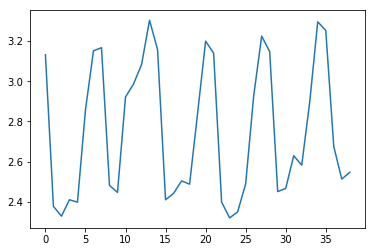

In [32]:
plt.plot(testpreds[129])

In [33]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [34]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.725905   
air_0164b9927d20bcc3_2017-04-23              1.415370   
air_0241aa3964b7f861_2017-04-23              2.396063   
air_0328696196e46f18_2017-04-23              2.154072   
air_034a3d5b40d5b1b1_2017-04-23              3.512639   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.617601  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.118012  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.979867  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.619890  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.536663

In [35]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [36]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [37]:
submission.to_csv("../submission/l5_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')